In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# import gensim
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jnske\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
general_df = pd.read_csv('./data/NSS_DS_data.thegeneral.csv')

In [4]:
general_df.head(20)

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida
5,10005,131010,adjuster out of office\r\nreassigned adjuster ...,none none closing um coverage at this time\r\n...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida
6,10006,131011,clear\r\n\r\nsiu claim\r\n\r\ncov cov issue ...,none none demand recd for clmt brockman\r\nlet...,cv was going through the traffic light and iv ...,back pain,front right side damaged head lights hood is d...,Minor,Atlanta Casualty Ops,Insured at fault,Collision in an intersection,2015-03-13 10:36:54.4740000,2016-05-23 13:07:36.1840000,South Carolina
7,10007,131012,c verified cvg for **** chev astro fl policy...,none rejected bills will be in the send back q...,received tow lien,unknown,none,NaN,Tampa Field Ops,No fault,Tow only,2015-03-13 17:18:57.3010000,2016-01-15 13:35:48.2900000,Florida
8,10008,131013,sc state trooper were on scene but they did no...,none none payment made payment made,iv hit a pot hole on the road iv locked up and...,sorenessribs shoulders and back,all over damage towed by workmans wrecker serv...,Minor,Large Loss 2,Insured at fault,Collision while merging / lane change,2015-03-15 17:06:18.1880000,2015-05-19 07:51:56.1780000,South Carolina
9,10009,131014,sc state trooper were on scene but they did no...,not injured not injured,iv hit a pot hole on the road iv locked up and...,was checked out by ambulance seat belt burn fr...,all over damage towed by workmans wrecker serv...,Minor,Large Loss 2,Insured at fault,Collision while merging / lane change,2015-03-15 17:06:18.1880000,2015-05-19 07:51:56.1780000,South Carolina


In [5]:
general_df.shape

(120657, 14)

In [6]:
general_df.FaultRatingName.unique()

array(['Other party at fault', 'Insured at fault', 'No fault',
       'Comparative Negligence', 'Fault unknown', nan], dtype=object)

In [7]:
general_df.FaultRatingName.value_counts()

Insured at fault          74304
Other party at fault      29394
Comparative Negligence     8178
No fault                   7395
Fault unknown              1385
Name: FaultRatingName, dtype: int64

#### These are our possible outcomes for the faults at claim level (Other Party at Fault, Insured at Fault, No Fault, Comparative Negligence, Fault Unknown). Insured at Fault consists of ~62% of all incidents.

In [8]:
tokenizer = RegexpTokenizer(r'\w+')

token_df = general_df.iloc[:, 2:11]
token_df.head()

,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName
0,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle
1,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change
2,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision
3,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision
4,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle


In [9]:
token_df['AccidentDescription_tok'] = token_df['AccidentDescription'].apply(tokenizer.tokenize)
# token_df['InjuryDescription_tok'] = token_df['InjuryDescription'].apply(tokenizer.tokenize)
token_df['DamageDescription_tok'] = token_df['DamageDescription'].apply(tokenizer.tokenize)
# token_df['FaultRatingName_tok'] = token_df['FaultRatingName'].apply(tokenizer.tokenize)
token_df['LossCauseName_tok'] = token_df['LossCauseName'].apply(tokenizer.tokenize)
    
token_df.head()

,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,AccidentDescription_tok,DamageDescription_tok,LossCauseName_tok
0,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,"[the, insured, was, test, driving, a, vehicle,...","[front, left, side, damages, towed, collision,...","[Collision, with, motor, vehicle]"
1,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,"[the, iv, was, driving, down, the, road, when,...","[front, right, headlight, front, side, of, bum...","[Collision, while, merging, lane, change]"
2,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,"[insured, was, stopped, at, the, stop, light, ...","[unknown, damages, rear, bumper, trunk, right,...","[Rear, end, collision]"
3,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,"[insured, was, stopped, at, the, stop, light, ...","[unknown, damages, rear, bumper, trunk, right,...","[Rear, end, collision]"
4,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,"[ov, re, host, veh]","[none, none, none]","[Collision, with, motor, vehicle]"


In [10]:
Counter(np.concatenate(token_df.LossCauseName_tok)).most_common(10)

[('Collision', 69056),
 ('end', 45122),
 ('IV', 41648),
 ('rear', 40596),
 ('CV', 40596),
 ('with', 28211),
 ('while', 21868),
 ('in', 19394),
 ('an', 19367),
 ('intersection', 19367)]

In [11]:
all_words = [word for tokens in token_df["AccidentDescription_tok"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in token_df["AccidentDescription_tok"]]

VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1993881 words total, with a vocabulary size of 8559
Max sentence length is 167


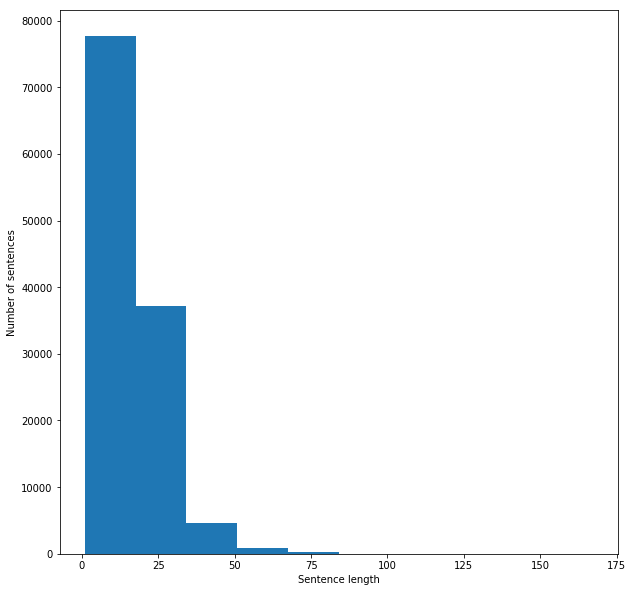

In [12]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [13]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = token_df["AccidentDescription"].tolist()
list_labels = token_df["FaultRatingName"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


accuracy = 0.512, precision = 0.673, recall = 0.512, f1 = 0.564


In [16]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation = 90)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

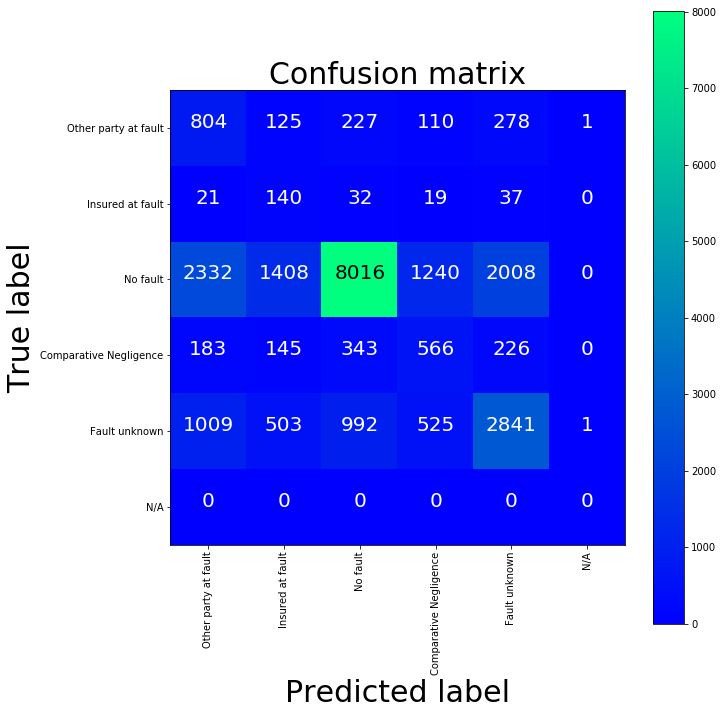

In [17]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Other party at fault', 'Insured at fault', 'No fault',
       'Comparative Negligence', 'Fault unknown', 'N/A'], normalize=False, title='Confusion matrix')
plt.show()
# print(cm)

In [18]:
all_words = [word for tokens in token_df["DamageDescription_tok"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in token_df["DamageDescription_tok"]]

VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

2376548 words total, with a vocabulary size of 13957
Max sentence length is 234


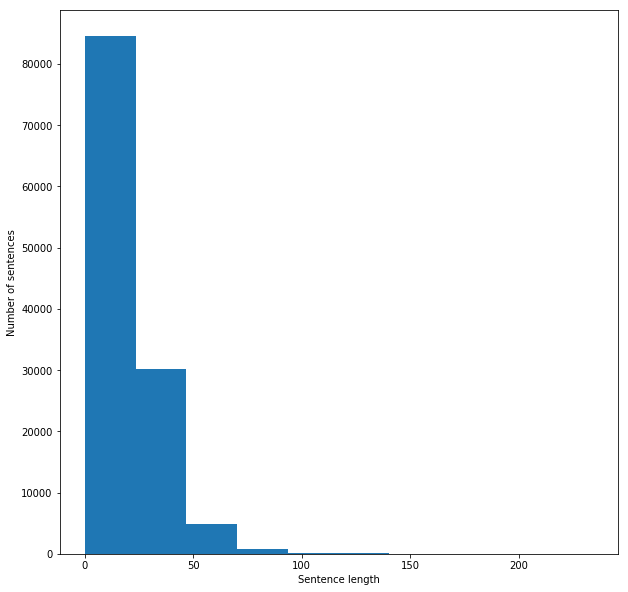

In [19]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [20]:
list_corpus = token_df["DamageDescription"].tolist()
list_labels = token_df["FaultRatingName"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Other party at fault', 'Insured at fault', 'No fault',
       'Comparative Negligence', 'Fault unknown', 'N/A'], normalize=False, title='Confusion matrix')
plt.show()

In [ ]:
all_words = [word for tokens in token_df["LossCauseName_tok"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in token_df["LossCauseName_tok"]]

VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

In [ ]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [ ]:
list_corpus = token_df["LossCauseName"].tolist()
list_labels = token_df["FaultRatingName"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

#### Accident descriptions seem to be the best indicator for determining fault, but still is 10% less accurate on its own than just assuming all accidents are the insured's fault.

In [ ]:
icm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Other party at fault', 'Insured at fault', 'No fault',
       'Comparative Negligence', 'Fault unknown', 'N/A'], normalize=False, title='Confusion matrix')
plt.show()